In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
!pip install scikit-plot
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc_curve
from sklearn.model_selection import KFold, StratifiedKFold,RepeatedStratifiedKFold, cross_val_score, KFold, RandomizedSearchCV,GridSearchCV, RepeatedKFold
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from scipy.special import expit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

In [3]:
from sklearn.metrics import roc_curve,auc

def plot_roc_curve(y_test, prediction, name_model):
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

    plt.grid()
    auc_score = round(auc(test_fpr, test_tpr),2)
    plt.plot(test_fpr, test_tpr, label=f"{name_model} - AUC ="+ str(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title(f" AUC(ROC curve) - {name_model}")
    plt.grid(color='black', linestyle='', linewidth=0.5)
    plt.show()

In [4]:
df_train = pd.read_csv("/content/Train_NOoutliers")
df_train = df_train.drop(columns=['Unnamed: 0'], axis = 1)
df_train = df_train.drop(columns=['outlier_detection'], axis = 1)
df_test = pd.read_csv("/content/Test_ripulito")
df_test = df_test.drop(columns=['Unnamed: 0'], axis = 1)

In [5]:
df_train.shape

(1809, 204)

In [6]:
df_test.shape

(624, 204)

elimino records con emozioni pari a neutral e surprised, poichè considero solo emozioni negative e positive come nuovo task

In [7]:
df_train_final = df_train[(df_train.emotion != "neutral") & (df_train.emotion != "surprised")]
df_train_final.shape

(1526, 204)

In [8]:
df_test_final = df_test[(df_test.emotion != "neutral") & (df_test.emotion != "surprised")]
df_test_final.shape

(528, 204)

aggiungo nuova colonna "positive" ad entrambi i dataset di train e test che mi dice se un record è caratterizzato da un'emozione positiva o negativa 

In [9]:
train_positive = []
for value in df_train_final['emotion']:
  if((value == 'happy') | (value == 'calm')):
    train_positive.append(1)
  else:
    train_positive.append(0)

In [10]:
test_positive = []
for value in df_test_final['emotion']:
  if((value == 'happy') | (value == 'calm')):
    test_positive.append(1)
  else:
    test_positive.append(0)

dataset finale da utilizzare

In [11]:
df_train_final = df_train_final.assign(positive = train_positive)
df_test_final = df_test_final.assign(positive = test_positive)
#1 se emozioni positive 
#0 se emozioni negative
#neutral e surprised NON incluse

Prendo in considerazione le feature originali dell'audio, ovvero: 
* sum, mean, std, min, max
* q01, q05, q25, q50, q75, q95, q99 (0.01, 0.05 quantiles..)
* kur, skew (kurtosis, skewness)



dataset con le sole variabili da considerare

In [12]:
train_original_audio= df_train_final[['sum', 'std', 'kur']]

In [13]:
test_original_audio = df_test_final[['sum', 'std', 'kur']]

In [14]:
train_original_audio

,sum,std,kur
4,0.137665,0.002956,13.236022
5,0.140289,0.003085,19.658058
6,0.112335,0.004295,9.780186
7,0.101654,0.004514,11.501726
8,0.078308,0.002414,10.454705
...,...,...,...
1796,-0.048676,0.014174,9.141644
1797,-0.043457,0.029479,23.689075
1798,-0.107056,0.030653,16.529312
1799,-0.003540,0.028224,17.369828


<Axes: >

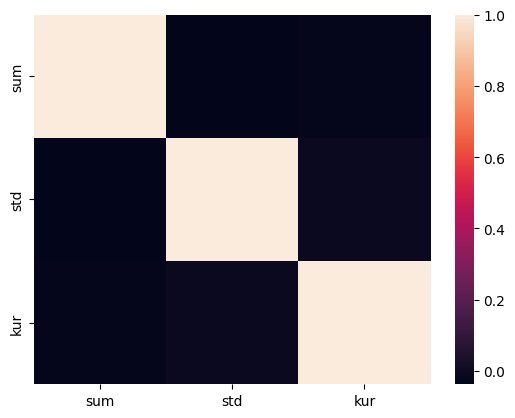

In [15]:
corr = train_original_audio.corr()
sns.heatmap(corr)
#non sono per niente correlate

Logistic Regression - una variabile indipendente

KUR


*   con sum fa schifo
*   con std è simile a kur, ma kur ha auc maggiore di std.




split X e y train e test

In [16]:
#One independent variable
X_train = train_original_audio[['kur']]
y_train = df_train_final[['positive']]
X_test = test_original_audio[['kur']]
y_test = df_test_final[['positive']]

normalizzazione dei valori in X_train e X_test 

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
logreg = LogisticRegression(random_state=42, solver = 'lbfgs', class_weight='balanced') #lbfgs è di default
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [19]:
print(f"Legend\n1: Positive\n0: Negative")
print(classification_report(y_test, y_pred))

Legend
1: Positive
0: Negative
              precision    recall  f1-score   support

           0       0.74      0.48      0.58       336
           1       0.44      0.70      0.54       192

    accuracy                           0.56       528
   macro avg       0.59      0.59      0.56       528
weighted avg       0.63      0.56      0.57       528



Legend
1: Positive
0: Negative


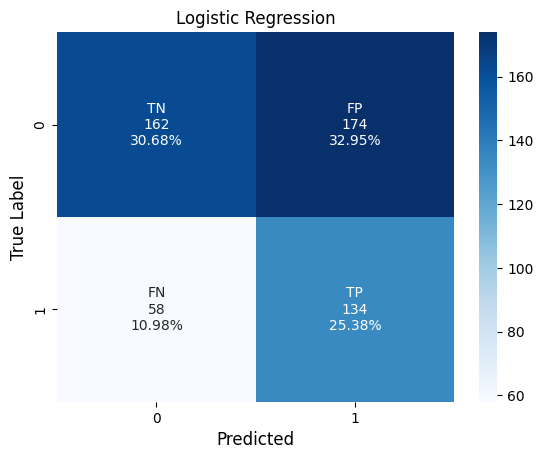

In [20]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(f"Legend\n1: Positive\n0: Negative")
make_confusion_matrix(cf_matrix, 'Logistic Regression')

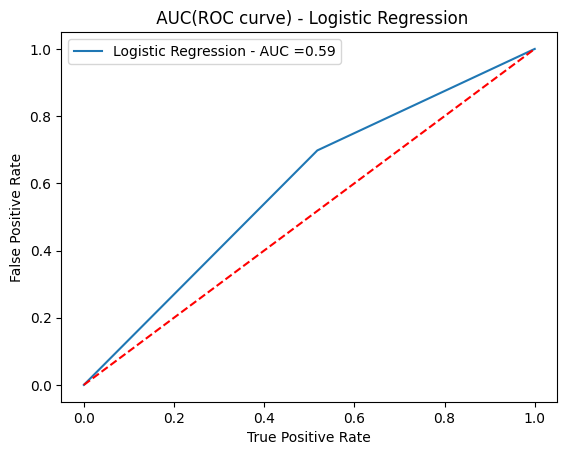

In [21]:
plot_roc_curve(y_test, y_pred, 'Logistic Regression')

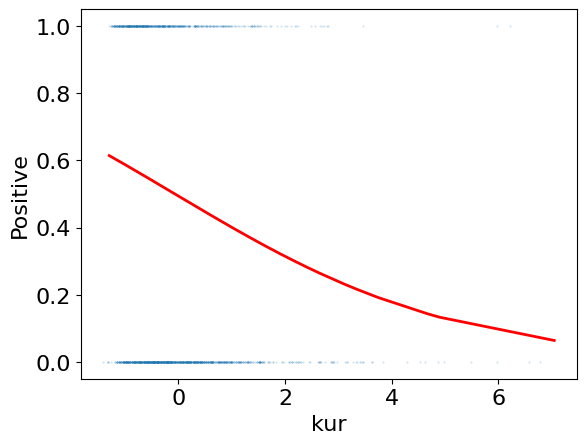

In [22]:
loss = expit(sorted(X_test) * logreg.coef_ + logreg.intercept_).ravel()
plt.plot(sorted(X_test), loss, color='red', linewidth=2)
plt.scatter(X_train, y_train, s=0.12, alpha=0.3)
plt.xlabel('kur', fontsize=16)
plt.ylabel('Positive', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [23]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

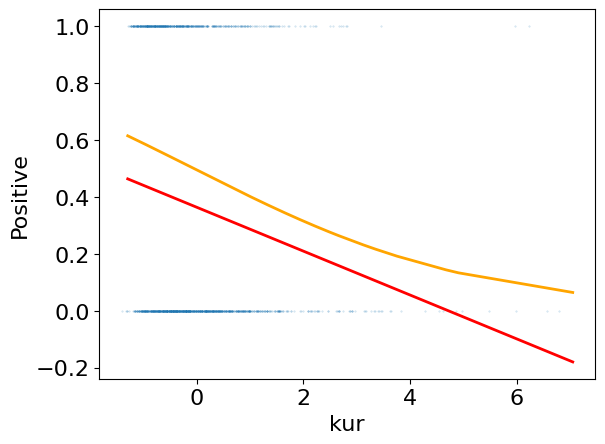

In [24]:
loss = expit(sorted(X_test) * logreg.coef_ + logreg.intercept_).ravel()
plt.plot(sorted(X_test), loss, color='orange', linewidth=2)
plt.scatter(X_train, y_train, s=0.12, alpha=0.3)
plt.plot(sorted(X_test), reg.coef_ * sorted(X_test) + reg.intercept_, color='red', linewidth=2)
plt.xlabel('kur', fontsize=16)
plt.ylabel('Positive', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Logistic regression - più variabili indipendeti (prese sempre dalle feature dell'original audio)

<Axes: >

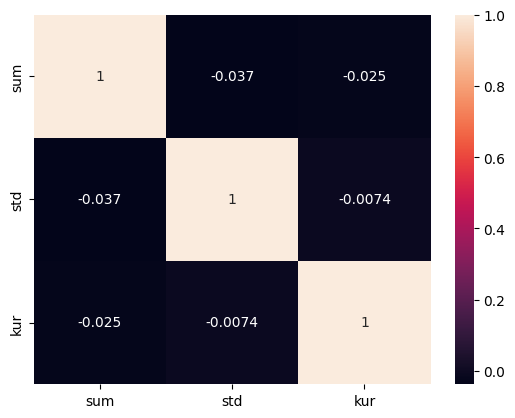

In [25]:
#Check echonest-audio features correlation
sns.heatmap(train_original_audio.corr(),annot=True)

In [26]:
X_train = train_original_audio
y_train = df_train_final[['positive']]
X_test = test_original_audio
y_test = df_test_final[['positive']]

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
logreg = LogisticRegression(random_state=42, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [29]:
print(f"Legend\n1: Positive\n0: Negative")
print(classification_report(y_test, y_pred))

Legend
1: Positive
0: Negative
              precision    recall  f1-score   support

           0       0.76      0.54      0.63       336
           1       0.46      0.70      0.56       192

    accuracy                           0.60       528
   macro avg       0.61      0.62      0.59       528
weighted avg       0.65      0.60      0.60       528



Legend
1: Positive
0: Negative


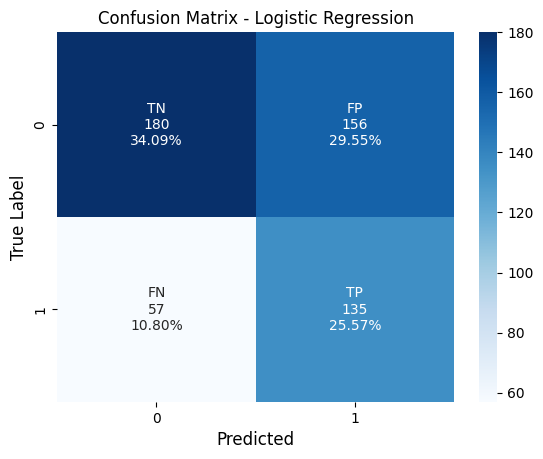

In [30]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(f"Legend\n1: Positive\n0: Negative")
make_confusion_matrix(cf_matrix, 'Confusion Matrix - Logistic Regression')

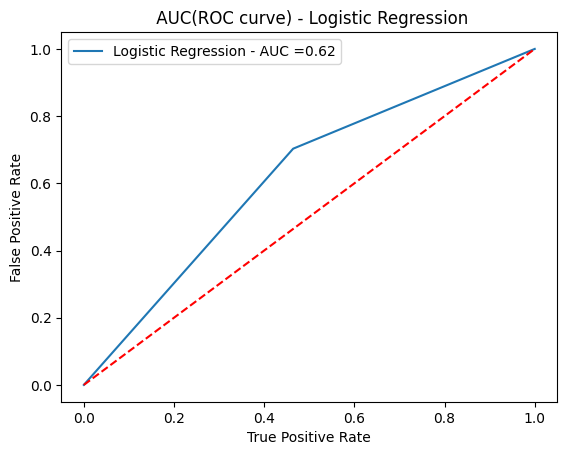

In [31]:
plot_roc_curve(y_test, y_pred, 'Logistic Regression')

In [32]:
X_test 

array([[ 0.03472253, -0.90703835, -0.34539029],
       [-0.02089769, -0.89534155, -0.19286725],
       [-0.13799077, -0.87774252, -0.25869128],
       ...,
       [ 0.09657602,  0.23301274, -0.63979555],
       [ 0.12868269,  0.23464738, -0.76371519],
       [ 0.06455442,  0.59302092, -0.60561288]])

In [147]:
#per vedere valori predetti male
"""for i in range(0,len(X_test)):
  z = np.array([X_test[i]])
  y = logreg.predict(z)
  print((i+1) ,X_test[i], y_test[i], y)"""

'for i in range(0,len(X_test)):\n  z = np.array([X_test[i]])\n  y = logreg.predict(z)\n  print((i+1) ,X_test[i], y_test[i], y)'

In [33]:
y_test.shape

(528, 1)

In [34]:
from sklearn.inspection import permutation_importance
result = permutation_importance(logreg, X_test, y_test, n_repeats=20, random_state=42)

sorted_idx = result.importances_mean.argsort()

result.importances[sorted_idx].shape

(3, 20)

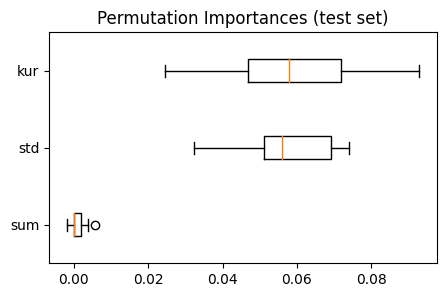

In [35]:
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(5,3))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=test_original_audio.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")

#fig.tight_layout()
plt.show()

Logistic Regression - multivariata (con tutte le variabili del dataset)

In [36]:
X_train = df_train_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_train = df_train_final[['positive']]
X_test = df_test_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_test = df_test_final[['positive']]

In [37]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
logreg = LogisticRegression(random_state=42, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [39]:
print(f"Legend\n1: Positive\n0: Negative")
print(classification_report(y_test, y_pred))

Legend
1: Positive
0: Negative
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       336
           1       0.53      0.67      0.59       192

    accuracy                           0.67       528
   macro avg       0.66      0.67      0.66       528
weighted avg       0.69      0.67      0.67       528



Legend
1: Positive
0: Negative


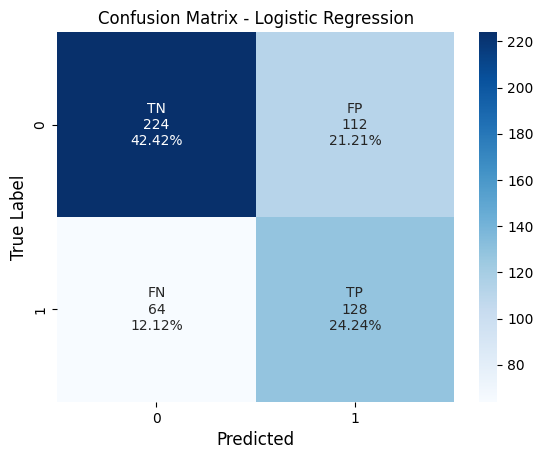

In [40]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(f"Legend\n1: Positive\n0: Negative")
make_confusion_matrix(cf_matrix, 'Confusion Matrix - Logistic Regression')

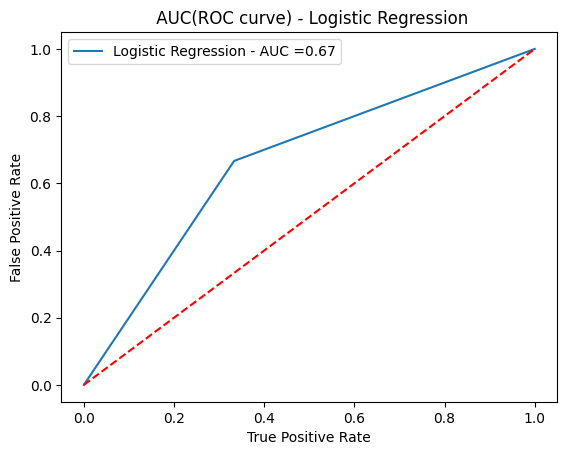

In [41]:
plot_roc_curve(y_test, y_pred, 'Logistic Regression')

In [42]:
from sklearn.inspection import permutation_importance
result = permutation_importance(logreg, X_test, y_test, n_repeats=20, random_state=42)

sorted_idx = result.importances_mean.argsort()

result.importances[sorted_idx].shape

(197, 20)

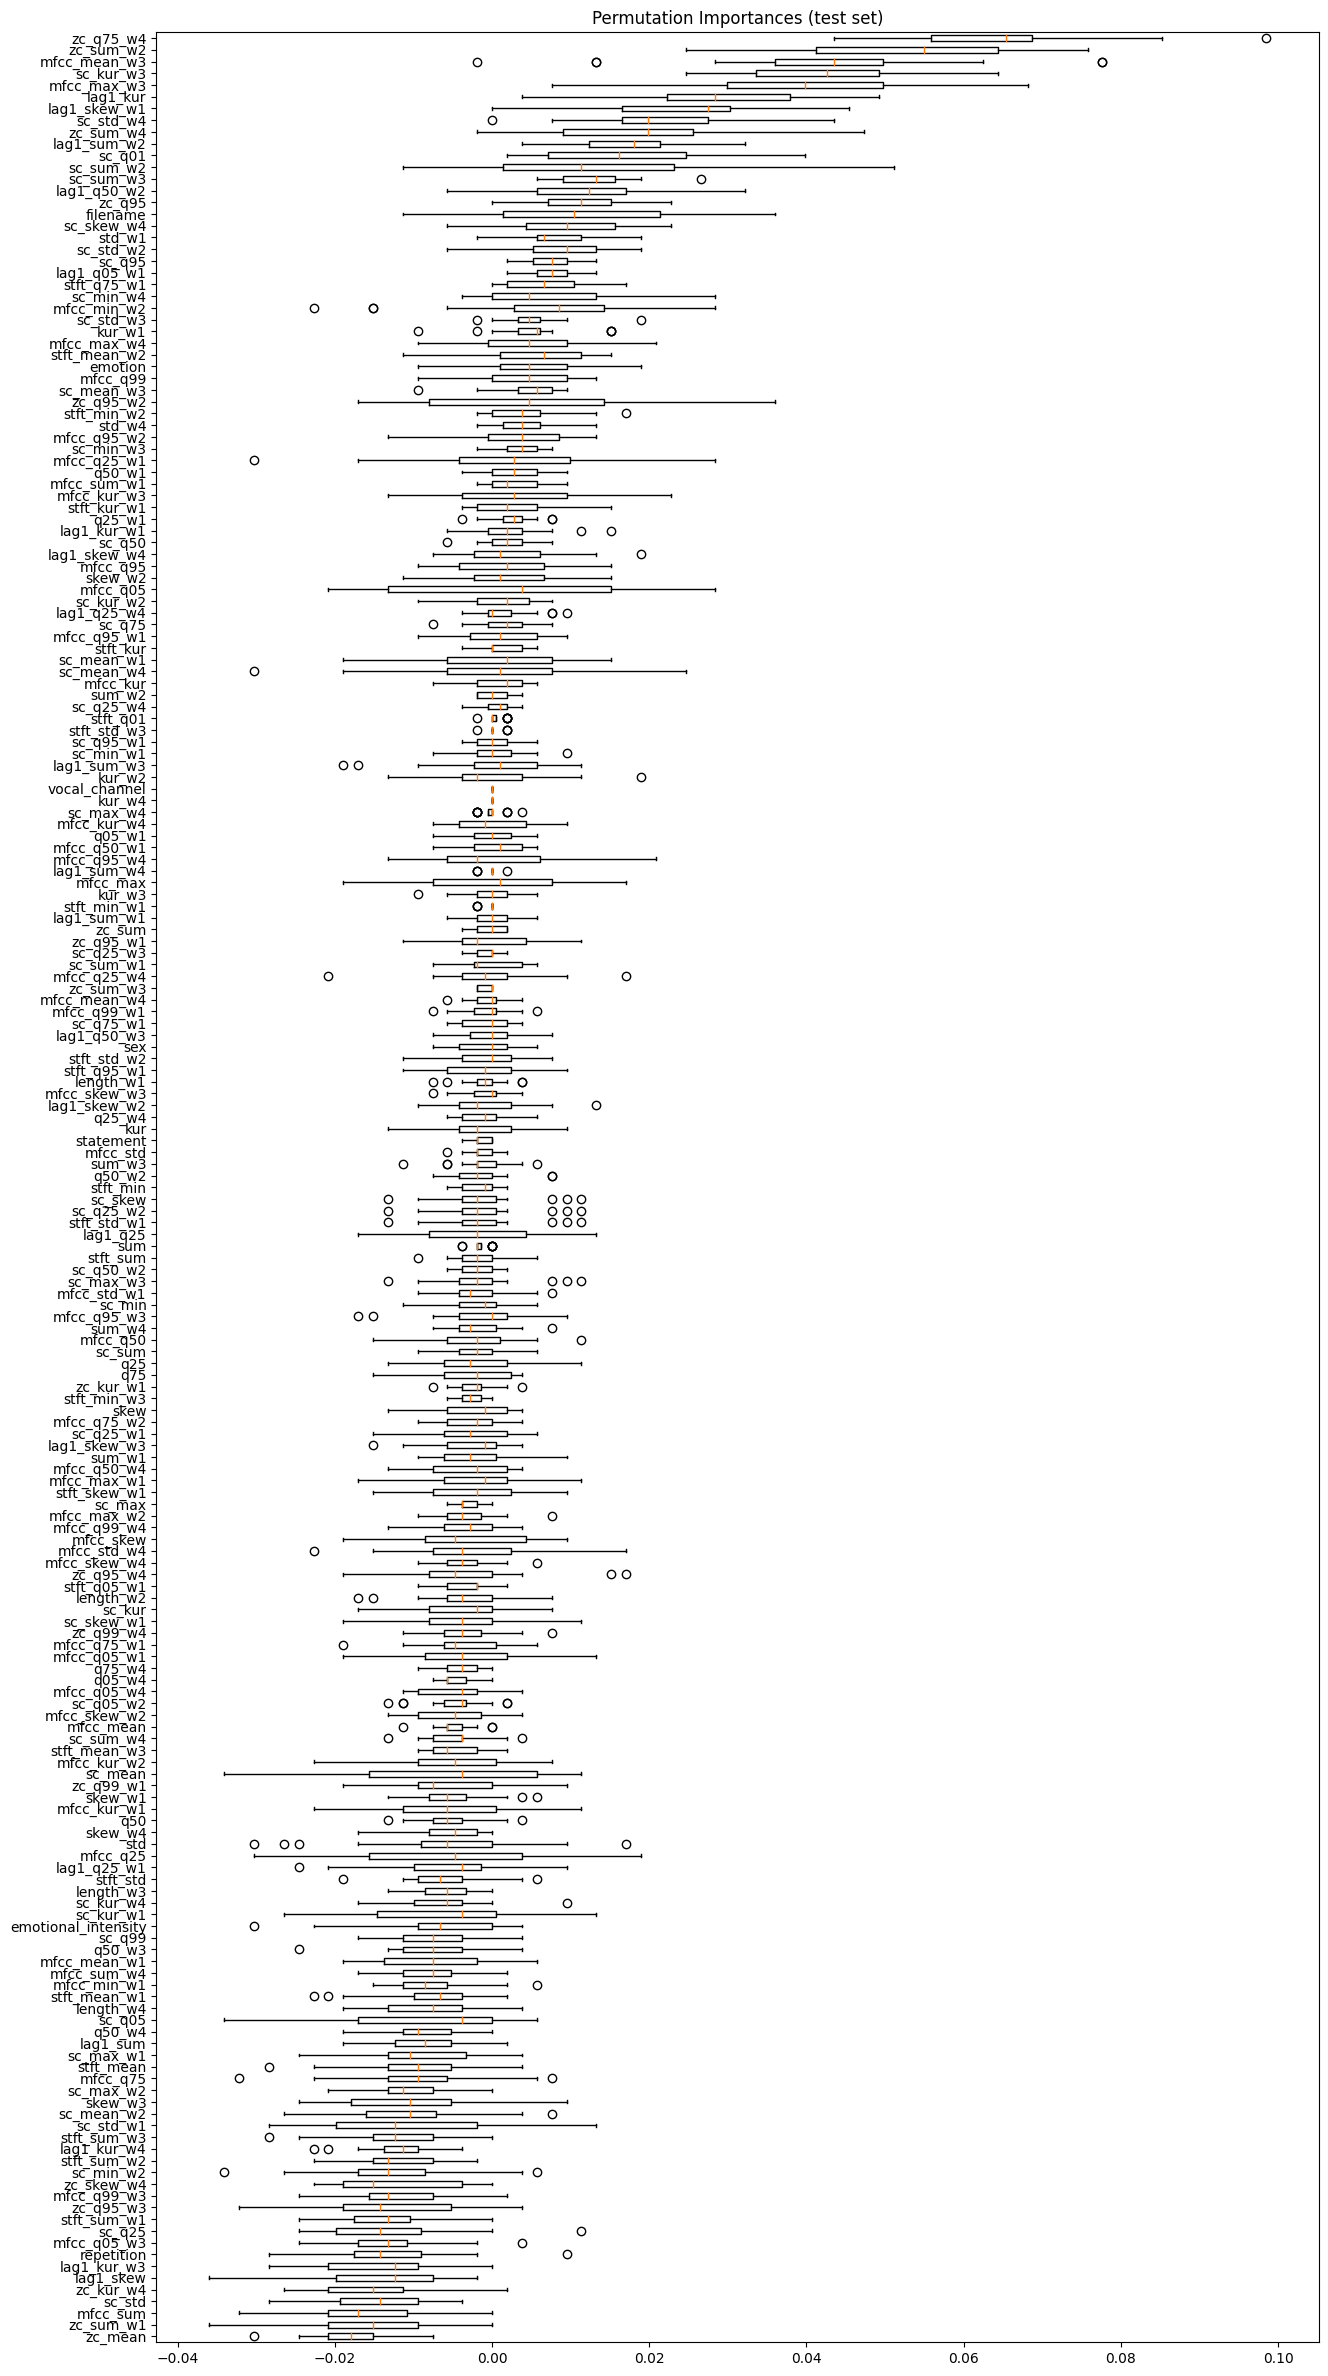

In [43]:
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(15,30))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=df_test_final.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")

#fig.tight_layout()
plt.show()

prova logistic regression univariata con zc_q75_w4.

In [44]:
#One independent variable
X_train = df_train_final[['zc_q75_w4']]
y_train = df_train_final[['positive']]
X_test = df_test_final[['zc_q75_w4']]
y_test = df_test_final[['positive']]

In [45]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
logreg = LogisticRegression(random_state=42, solver = 'lbfgs', class_weight='balanced') #lbfgs è di default
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [47]:
print(f"Legend\n1: Positive\n0: Negative")
print(classification_report(y_test, y_pred))

Legend
1: Positive
0: Negative
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       336
           1       0.00      0.00      0.00       192

    accuracy                           0.64       528
   macro avg       0.32      0.50      0.39       528
weighted avg       0.40      0.64      0.49       528



Legend
1: Positive
0: Negative


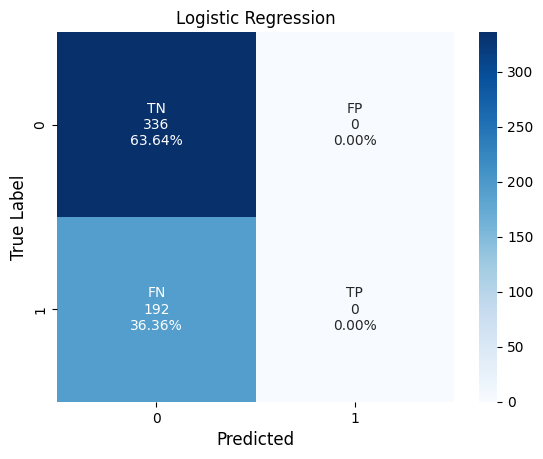

In [48]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(f"Legend\n1: Positive\n0: Negative")
make_confusion_matrix(cf_matrix, 'Logistic Regression')

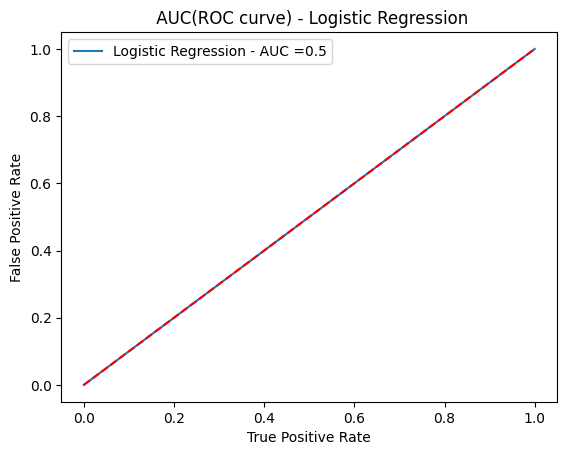

In [49]:
plot_roc_curve(y_test, y_pred, 'Logistic Regression')

prova inutile giusto per vedere cosa usciva con sottoinsieme features audio originale

In [151]:
from yellowbrick.model_selection import RFECV

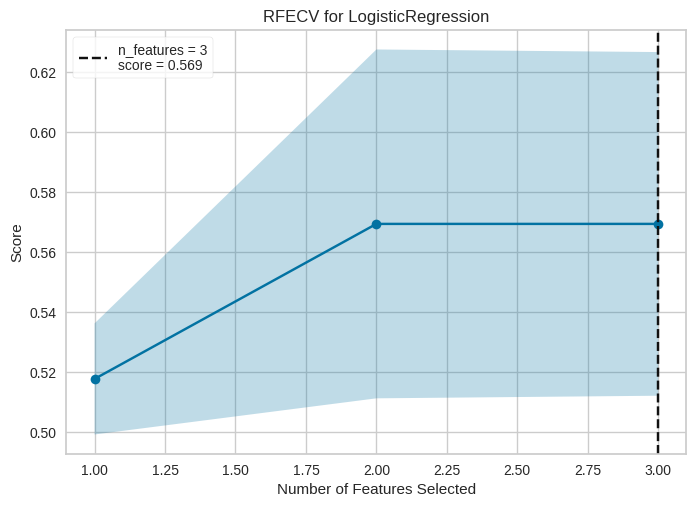

<Axes: title={'center': 'RFECV for LogisticRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [152]:
# Instantiate RFECV visualizer with a linear SVM classifier
visualizer = RFECV(LogisticRegression(random_state=42, class_weight='balanced'))

visualizer.fit(X_train, y_train) 
# Fit the data to the visualizer
visualizer.show() 